In [1]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
#from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import skew

# Data Splitting and Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation Metrics
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
import pickle

# Saving Model
from joblib import dump

# Others
#import shap
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier

# Set seaborn defaults and suppress warnings
sns.set()
#warnings.filterwarnings('ignore')

In [2]:
df_tr = pd.read_csv("Paitients_Files_Train.csv")
df_ts = pd.read_csv("Paitients_Files_Test.csv")

# Dataset Overview

### About this Data
- ID: number to represent patient ID
- PRG: Plasma glucose
- PL: Blood Work Result-1 (mu U/ml)
- PR: Blood Pressure (mm Hg)
- SK: Blood Work Result-2 (mm)
- TS: Blood Work Result-3 (mu U/ml)
- M11: Body mass index (weight in kg)/(height in m)^2
- BD2: Blood Work Result-4 (mu U/ml)
- Age: patients age (years)
- Insurance: If a patient holds a valid insurance card
- Sepsis:  Positive: if a patient in ICU will develop a sepsis , and
      Negative: otherwise

In [3]:
#First Five Rows of the train dataset
df_tr.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [4]:
#First Five Rows of the test dataset
df_ts.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [5]:
#basic information about columns in Train Dataset
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [6]:
#basic information about columns in Test Dataset
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [7]:
#Check dimension of train dataset
print(df_tr.shape)
print("Number of rows for Train data:", df_tr.shape[0])
print("Number of columns for Train data:", df_tr.shape[1])

(599, 11)
Number of rows for Train data: 599
Number of columns for Train data: 11


In [8]:
#Check dimension of test dataset
print(df_ts.shape)
print("Number of rows for Test Data:", df_ts.shape[0])
print("Number of columns for Test Data:", df_ts.shape[1])

(169, 10)
Number of rows for Test Data: 169
Number of columns for Test Data: 10


In [9]:
#Explore the summary statistics of numerical columns:
df_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


##### **PRG**

- Count: 599
- Mean: 3.82
- Standard Deviation: 3.36
- Range: 0 to 17

##### **PL**

- Count: 599
- Mean: 120.15
- Standard Deviation: 32.68
- Range: 0 to 198

##### **PR**

- Count: 599
- Mean: 68.73
- Standard Deviation: 19.34
- Range: 0 to 122

##### **SK**

- Count: 599
- Mean: 20.56
- Standard Deviation: 16.02
- Range: 0 to 99

##### **TS**

- Count: 599
- Mean: 79.46
- Standard Deviation: 116.58
- Range: 0 to 846

##### **M11**

- Count: 599
- Mean: 31.92
- Standard Deviation: 8.01
- Range: 0 to 67.1

##### **BD2**

- Count: 599
- Mean: 0.48
- Standard Deviation: 0.34
- Range: 0.078 to 2.42

##### **Age**

- Count: 599
- Mean: 33.29
- Standard Deviation: 11.83
- Range: 21 to 81

##### **Insurance**

- Count: 599
- Mean: 0.686
- Standard Deviation: 0.464
- Range: 0 to 1
- Proportion with Insurance: 0.686 (68.6%)


In [10]:
#Explore the summary statistics of numerical columns:
df_ts.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,169.0,3.917160,3.402415,0.0,1.000,3.000,6.000,13.000
PL,169.0,123.520710,29.259123,56.0,102.000,120.000,141.000,199.000
PR,169.0,70.426036,19.426805,0.0,62.000,74.000,80.000,114.000
SK,169.0,20.443787,15.764962,0.0,0.000,23.000,32.000,49.000
TS,169.0,81.000000,110.720852,0.0,0.000,0.000,135.000,540.000
M11,169.0,32.249704,7.444886,0.0,27.600,32.400,36.600,57.300
BD2,169.0,0.438876,0.306935,0.1,0.223,0.343,0.587,1.698
Age,169.0,33.065089,11.548110,21.0,24.000,28.000,42.000,70.000
Insurance,169.0,0.727811,0.446410,0.0,0.000,1.000,1.000,1.000


##### **PRG**

- Count: 169
- Mean: 3.9171
- Standard Deviation: 3.4024
- Range: 0 to 13

##### **PL**

- Count: 169
- Mean: 123.5207
- Standard Deviation: 29.2591
- Range: 56 to 199

##### **PR**

- Count: 169
- Mean: 70.4260
- Standard Deviation: 19.4268
- Range: 0 to 114

##### **SK**

- Count: 169
- Mean: 20.4437
- Standard Deviation: 15.7649
- Range: 0 to 49

##### **TS**

- Count: 169
- Mean: 81.00
- Standard Deviation: 110.7208
- Range: 0 to 540

##### **M11**

- Count: 169
- Mean: 32.2497
- Standard Deviation: 7.4448
- Range: 0 to 57.3

##### **BD2**

- Count: 169
- Mean: 0.4388
- Standard Deviation: 0.3069
- Range: 0.1 to 1.698

##### **Age**

- Count: 169
- Mean: 33.065
- Standard Deviation: 11.5481
- Range: 21 to 70

##### **Insurance**

- Count: 169
- Mean: 0.7278
- Standard Deviation: 0.446
- Range: 0 to 1
- Proportion with Insurance: 0.7278 (72.78%)


In [11]:
# create a function to print the number of unique values
def print_unique_values(data):
    values = {}
    for col in data.columns:
        number = data[col].nunique()
        print(f'{col}: has {number} of unique values') 

In [12]:
print_unique_values(df_tr)

ID: has 599 of unique values
PRG: has 17 of unique values
PL: has 129 of unique values
PR: has 44 of unique values
SK: has 51 of unique values
TS: has 164 of unique values
M11: has 233 of unique values
BD2: has 437 of unique values
Age: has 50 of unique values
Insurance: has 2 of unique values
Sepssis: has 2 of unique values


In [13]:
print_unique_values(df_ts)

ID: has 169 of unique values
PRG: has 14 of unique values
PL: has 85 of unique values
PR: has 33 of unique values
SK: has 36 of unique values
TS: has 66 of unique values
M11: has 122 of unique values
BD2: has 156 of unique values
Age: has 39 of unique values
Insurance: has 2 of unique values


## Univariate Analysis 

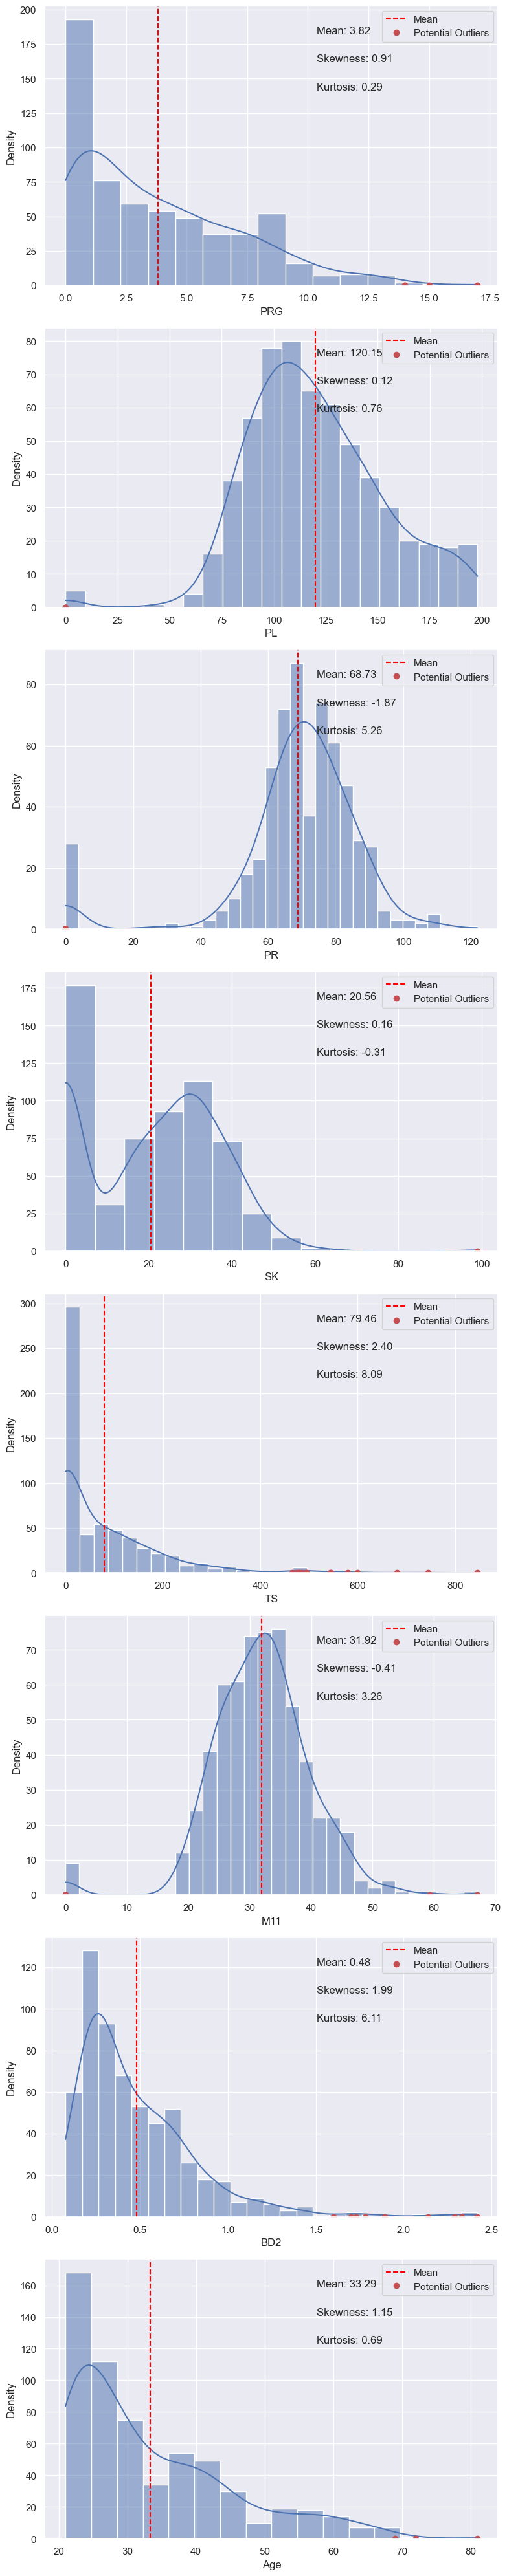

In [14]:
cols_to_plot = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age']

fig, axes = plt.subplots(nrows=len(cols_to_plot), figsize=(8, 40))

for i, col in enumerate(cols_to_plot):
    sns.histplot(data=df_tr, x=col, kde=True, ax=axes[i], fill=True)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    
    mean_val = df_tr[col].mean()
    skewness_val = df_tr[col].skew()
    kurtosis_val = df_tr[col].kurtosis()
    
    axes[i].text(0.6, 0.9, f'Mean: {mean_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.8, f'Skewness: {skewness_val:.2f}', transform=axes[i].transAxes)
    axes[i].text(0.6, 0.7, f'Kurtosis: {kurtosis_val:.2f}', transform=axes[i].transAxes)
    
    axes[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    
    outliers = df_tr[(df_tr[col] > mean_val + 3 * df_tr[col].std()) | (df_tr[col] < mean_val - 3 * df_tr[col].std())]
    axes[i].plot(outliers[col], [0] * len(outliers), 'ro', label='Potential Outliers')
    
    axes[i].legend()

plt.tight_layout()
plt.show()


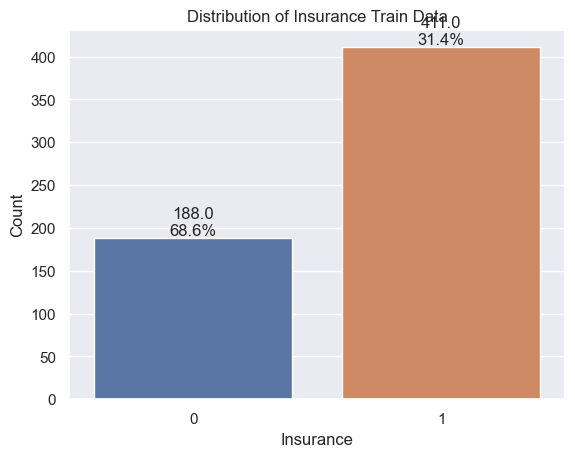

In [15]:
# Count plot for "Insurance" 
sns.countplot(data=df_tr, x='Insurance')

# Set labels
plt.xlabel('Insurance')
plt.ylabel('Count')

# Set title
plt.title('Distribution of Insurance Train Data')

# Calculate percentage distribution
total = len(df_tr['Insurance'])
percentages = df_tr['Insurance'].value_counts(normalize=True) * 100

# Add data labels and percentage annotations
for p, percentage in zip(plt.gca().patches, percentages):
    count = p.get_height()
    percentage_label = f'{percentage:.1f}%'
    plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.show()

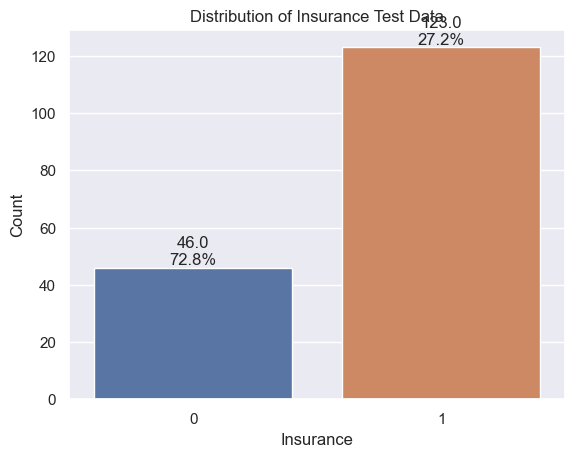

In [16]:
# Count plot for "Insurance" 
sns.countplot(data=df_ts, x='Insurance')

# Set labels
plt.xlabel('Insurance')
plt.ylabel('Count')

# Set title
plt.title('Distribution of Insurance Test Data')

# Calculate percentage distribution
total = len(df_ts['Insurance'])
percentages = df_ts['Insurance'].value_counts(normalize=True) * 100

# Add data labels and percentage annotations
for p, percentage in zip(plt.gca().patches, percentages):
    count = p.get_height()
    percentage_label = f'{percentage:.1f}%'
    plt.gca().annotate(f'{count}\n{percentage_label}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')


plt.show()

In [17]:
# Encoding the target variable
df_tr['Sepssis_Encoded'] = df_tr['Sepssis'].map({'Negative': 0, 'Positive': 1})

# Dropping unneeded column
df_tr.drop('ID', axis=1, inplace=True)
df_ts.drop('ID', axis=1, inplace=True)

## BIVARIATE ANALYSIS

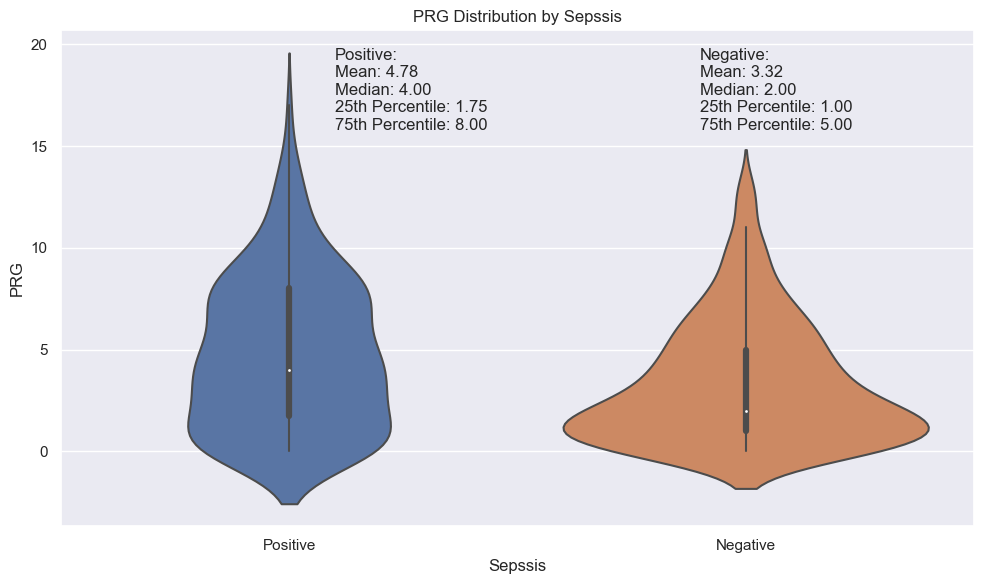

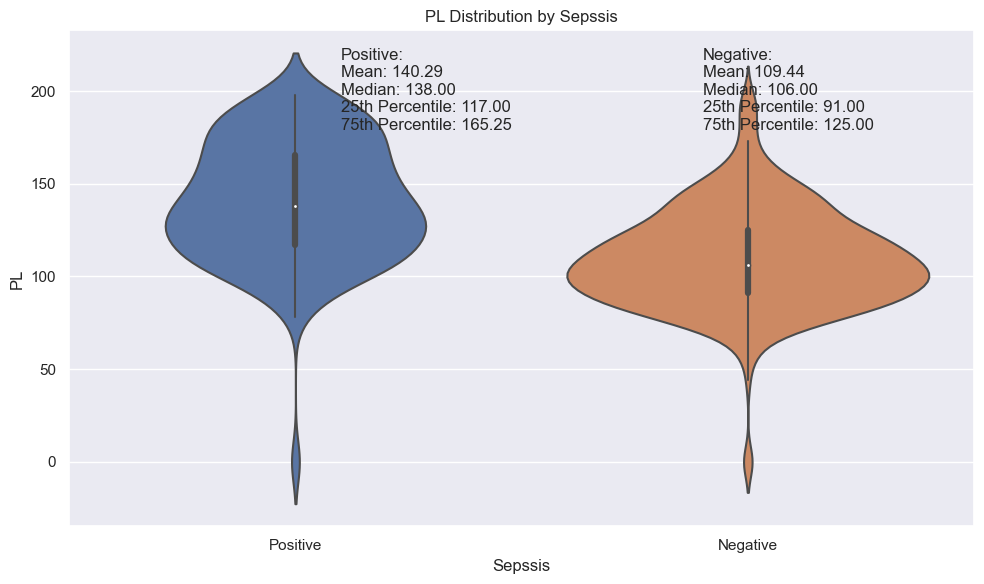

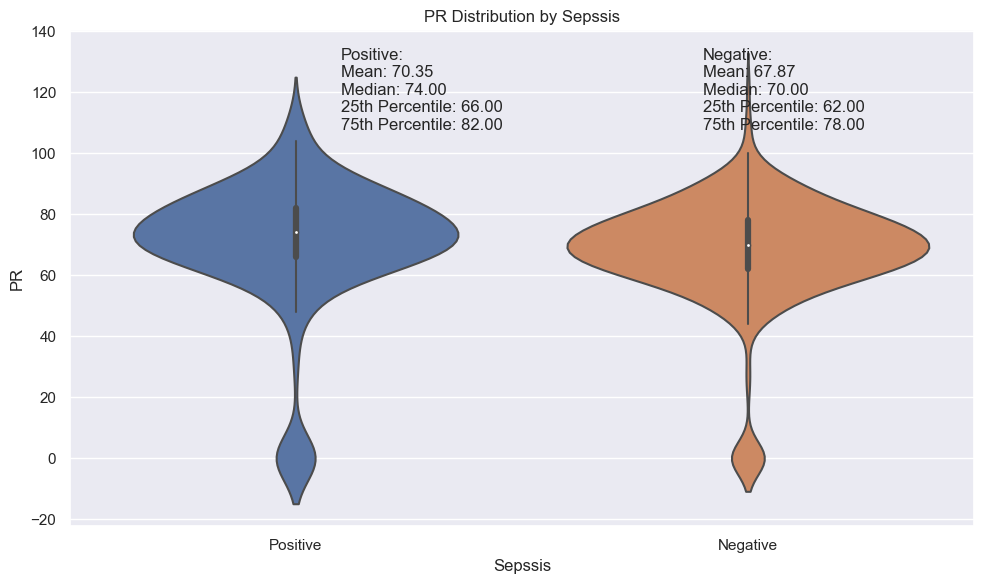

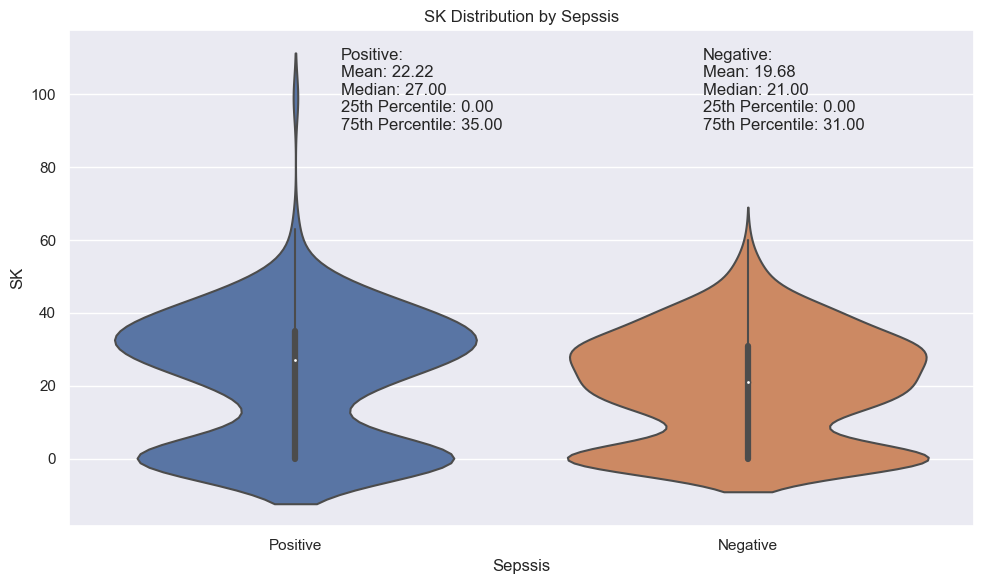

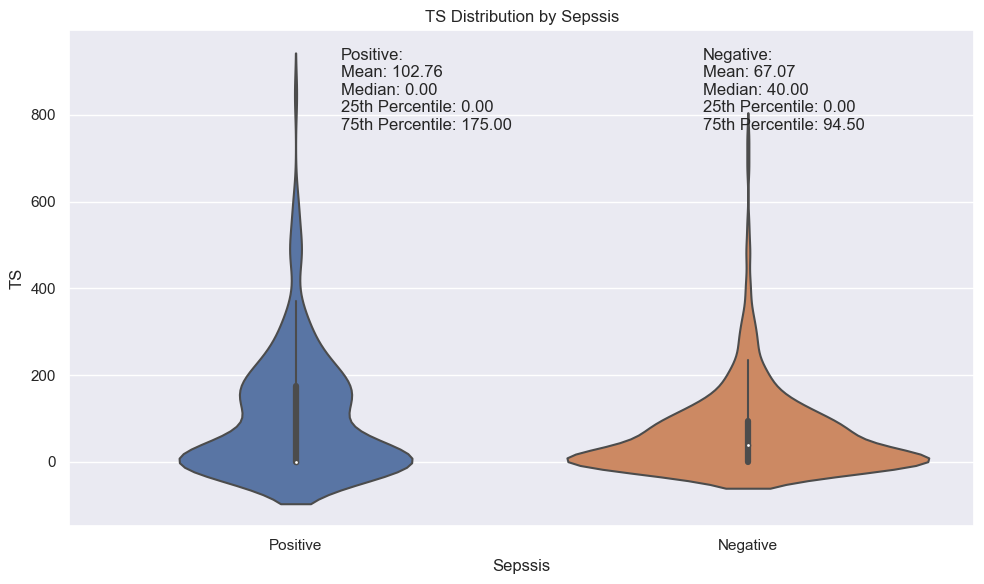

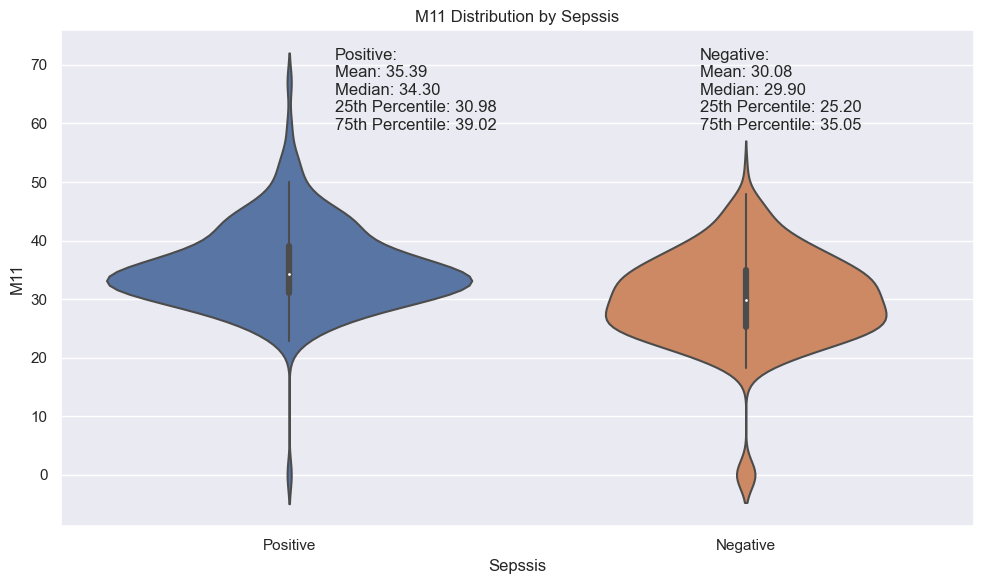

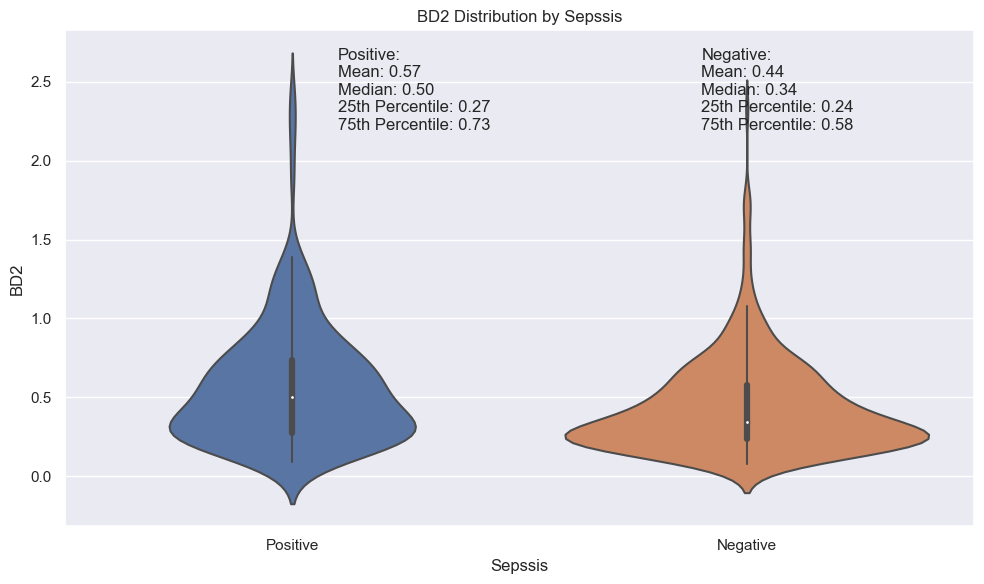

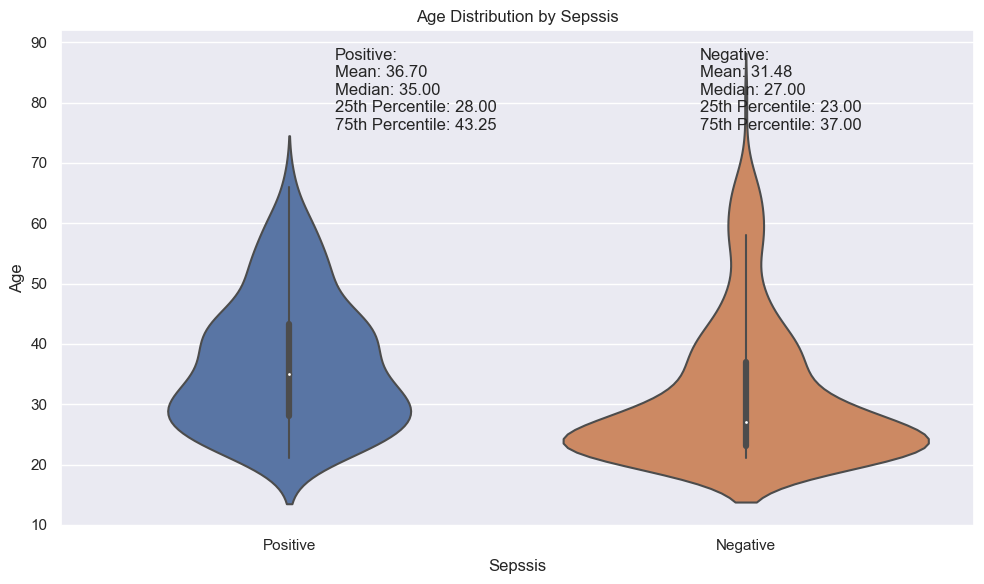

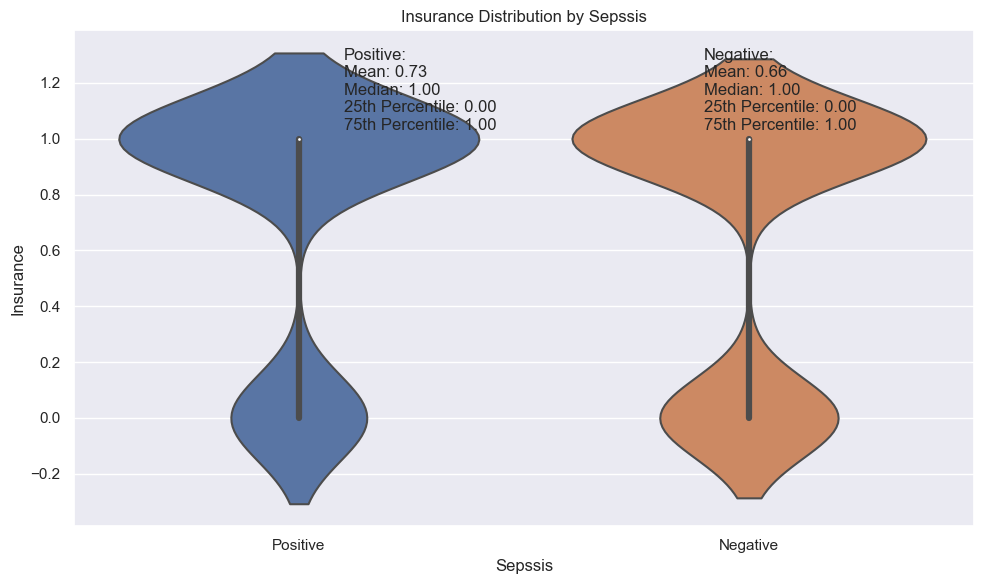

In [18]:
# Numerical Variables - Violin plots with statistics
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_tr, x='Sepssis', y=var)
    plt.xlabel('Sepssis')
    plt.ylabel(var)
    plt.title(f'{var} Distribution by Sepssis')
    
    # Calculate statistics
    positive_vals = df_tr[df_tr['Sepssis'] == 'Positive'][var]
    negative_vals = df_tr[df_tr['Sepssis'] == 'Negative'][var]
    stat_dict = {
        'Positive': {
            'Mean': np.mean(positive_vals),
            'Median': np.median(positive_vals),
            '25th Percentile': np.percentile(positive_vals, 25),
            '75th Percentile': np.percentile(positive_vals, 75)
        },
        'Negative': {
            'Mean': np.mean(negative_vals),
            'Median': np.median(negative_vals),
            '25th Percentile': np.percentile(negative_vals, 25),
            '75th Percentile': np.percentile(negative_vals, 75)
        }
    }
    
    # Add statistics as text annotations
    plt.text(0.30, 0.8, f"Positive:\nMean: {stat_dict['Positive']['Mean']:.2f}\nMedian: {stat_dict['Positive']['Median']:.2f}\n25th Percentile: {stat_dict['Positive']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Positive']['75th Percentile']:.2f}", transform=plt.gca().transAxes)
    plt.text(0.70, 0.8, f"Negative:\nMean: {stat_dict['Negative']['Mean']:.2f}\nMedian: {stat_dict['Negative']['Median']:.2f}\n25th Percentile: {stat_dict['Negative']['25th Percentile']:.2f}\n75th Percentile: {stat_dict['Negative']['75th Percentile']:.2f}", transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()



In [19]:
# Calculate correlation coefficients
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df_tr[numerical_vars + ['Sepssis_Encoded']].corr()

# Print correlation coefficients
for var in numerical_vars:
    correlation = correlations.loc[var, 'Sepssis_Encoded']
    print(f"Pearson correlation between 'Sepssis_Encoded' and '{var}': {correlation:.2f}")


Pearson correlation between 'Sepssis_Encoded' and 'PRG': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'PL': 0.45
Pearson correlation between 'Sepssis_Encoded' and 'PR': 0.06
Pearson correlation between 'Sepssis_Encoded' and 'SK': 0.08
Pearson correlation between 'Sepssis_Encoded' and 'TS': 0.15
Pearson correlation between 'Sepssis_Encoded' and 'M11': 0.32
Pearson correlation between 'Sepssis_Encoded' and 'BD2': 0.18
Pearson correlation between 'Sepssis_Encoded' and 'Age': 0.21
Pearson correlation between 'Sepssis_Encoded' and 'Insurance': 0.06


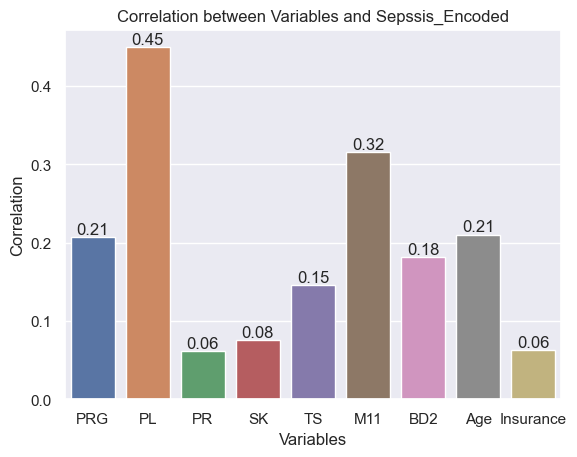

In [20]:
numerical_vars = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']
correlations = df_tr[numerical_vars + ['Sepssis_Encoded']].corr()

# Get correlation values
correlation_values = correlations.loc[numerical_vars, 'Sepssis_Encoded']

# Create bar plot using Seaborn
sns.barplot(x=numerical_vars, y=correlation_values)

# Add data labels to the bar plot
for i, val in enumerate(correlation_values):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.title('Correlation between Variables and Sepssis_Encoded')

# Show the plot
plt.show()

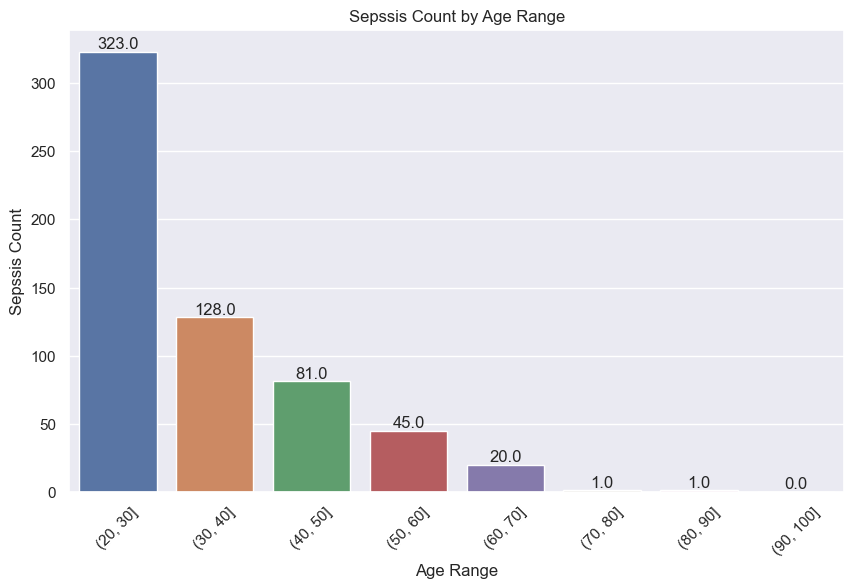

In [21]:
# Assuming your dataset is stored in a DataFrame called 'df'
age_ranges = pd.cut(df_tr['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100])
grouped_data = df_tr.groupby(age_ranges)

# Calculate the count of 'Sepssis' for each age range
count_sepsis_by_age = grouped_data['Sepssis'].count().reset_index()

# Plotting the count of 'Sepssis' for each age range
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=count_sepsis_by_age, x='Age', y='Sepssis')
ax.set(xlabel='Age Range', ylabel='Sepssis Count', title='Sepssis Count by Age Range')
plt.xticks(rotation=45)

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

## MULTIVARIATE ANALYSIS

### Correlation between the columns in the Train dataset

In [22]:
# Dropping the object column
df1 = df_tr.copy()
df1.drop('Sepssis', axis=1, inplace=True)

In [23]:

# find the correlation between the columns
corr_matrix = df1.corr()
corr_matrix

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis_Encoded
PRG,1.000000,0.139541,0.116680,-0.080902,-0.054812,0.033482,-0.052230,0.532545,0.084631,0.207115
PL,0.139541,1.000000,0.143064,0.054430,0.339818,0.215949,0.144665,0.274057,0.050993,0.449719
PR,0.116680,0.143064,1.000000,0.197535,0.095281,0.269482,0.008318,0.225625,-0.025365,0.061086
SK,-0.080902,0.054430,0.197535,1.000000,0.429068,0.377950,0.176592,-0.121553,-0.017360,0.075585
TS,-0.054812,0.339818,0.095281,0.429068,1.000000,0.184747,0.218313,-0.011523,0.041560,0.145892
M11,0.033482,0.215949,0.269482,0.377950,0.184747,1.000000,0.127675,0.046117,0.026826,0.315894
BD2,-0.052230,0.144665,0.008318,0.176592,0.218313,0.127675,1.000000,0.033567,0.006114,0.181561
Age,0.532545,0.274057,0.225625,-0.121553,-0.011523,0.046117,0.033567,1.000000,0.054368,0.210234
Insurance,0.084631,0.050993,-0.025365,-0.017360,0.041560,0.026826,0.006114,0.054368,1.000000,0.062582
Sepssis_Encoded,0.207115,0.449719,0.061086,0.075585,0.145892,0.315894,0.181561,0.210234,0.062582,1.000000


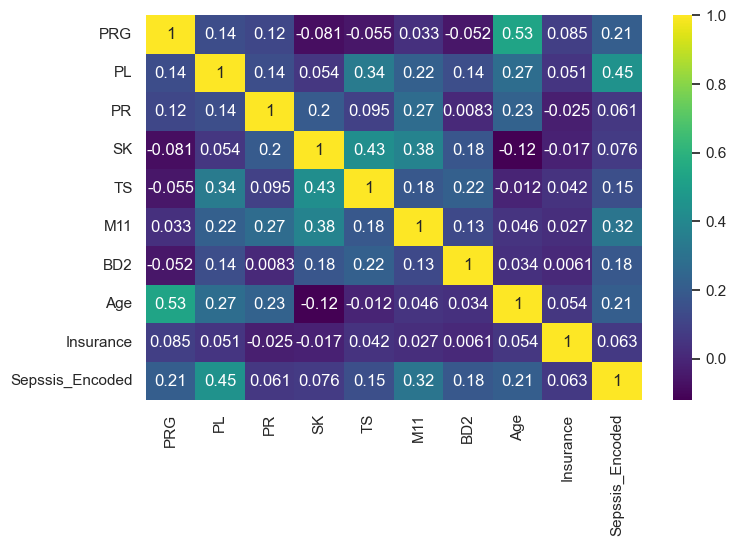

In [24]:
# Plot a heatmap for the correlations
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.show();

In [25]:
# Find the minimum correlation and corresponding columns
min_corr = corr_matrix.min().min()
min_corr_cols = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.index:
        if corr_matrix.loc[col1, col2] == min_corr:
            min_corr_cols.append((col1, col2))

print("Minimum Correlation:", min_corr)
print("Columns with Minimum Correlation:", min_corr_cols)

Minimum Correlation: -0.12155329275228288
Columns with Minimum Correlation: [('SK', 'Age'), ('Age', 'SK')]


In [26]:
# get the minimum value
max_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
            .max().max())  
# get the maximum value (excluding same columns)
# get the columns involved
max_corr_cols = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
                 .stack().idxmax()) 

print('The maximun correlation was:', max_corr)
print('The columns involved are:', max_corr_cols)

The maximun correlation was: 0.5325446086908504
The columns involved are: ('PRG', 'Age')


### Correlation between the columns in the Test dataset

In [27]:
# find the correlation between the columns
corr_matrix_t = df_ts.corr()
corr_matrix_t

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
PRG,1.000000,0.088808,0.226032,-0.084315,-0.143327,-0.042980,0.041405,0.587779,0.000742
PL,0.088808,1.000000,0.184448,0.070199,0.296815,0.240396,0.119497,0.224456,-0.040125
PR,0.226032,0.184448,1.000000,0.243956,0.064700,0.327511,0.179641,0.292158,-0.134804
SK,-0.084315,0.070199,0.243956,1.000000,0.466503,0.450529,0.214038,-0.086018,-0.023332
TS,-0.143327,0.296815,0.064700,0.466503,1.000000,0.250437,0.051053,-0.159589,-0.114407
M11,-0.042980,0.240396,0.327511,0.450529,0.250437,1.000000,0.201224,-0.001741,-0.001815
BD2,0.041405,0.119497,0.179641,0.214038,0.051053,0.201224,1.000000,0.031738,0.094673
Age,0.587779,0.224456,0.292158,-0.086018,-0.159589,-0.001741,0.031738,1.000000,-0.013863
Insurance,0.000742,-0.040125,-0.134804,-0.023332,-0.114407,-0.001815,0.094673,-0.013863,1.000000


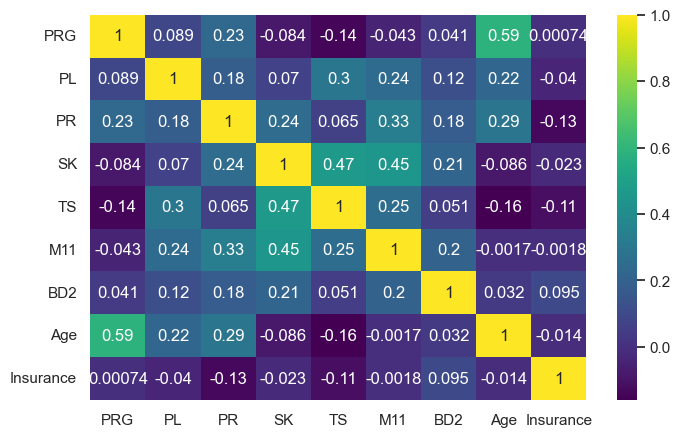

In [28]:
# Plot a heatmap for the correlations
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_t, annot=True, cmap='viridis')
plt.show();

In [29]:
# Find the minimum correlation and corresponding columns
min_corr_t = corr_matrix_t.min().min()
min_corr_cols_t = []

for col1 in corr_matrix_t.columns:
    for col2 in corr_matrix_t.index:
        if corr_matrix_t.loc[col1, col2] == min_corr_t:
            min_corr_cols_t.append((col1, col2))

print("Minimum Correlation:", min_corr_t)
print("Columns with Minimum Correlation:", min_corr_cols_t)

Minimum Correlation: -0.15958934271107075
Columns with Minimum Correlation: [('TS', 'Age'), ('Age', 'TS')]


In [30]:
# get the maximum value
max_corr_t = (corr_matrix_t.where(np.triu(np.ones(corr_matrix_t.shape), k=1).astype(np.bool_))
            .max().max())  
# get the maximum value (excluding same columns)
# get the columns involved
max_corr_cols_t = (corr_matrix_t.where(np.triu(np.ones(corr_matrix_t.shape), k=1).astype(np.bool_))
                 .stack().idxmax()) 

print('The maximun correlation was:', max_corr_t)
print('The columns involved are:', max_corr_cols_t)

The maximun correlation was: 0.5877793041318986
The columns involved are: ('PRG', 'Age')


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


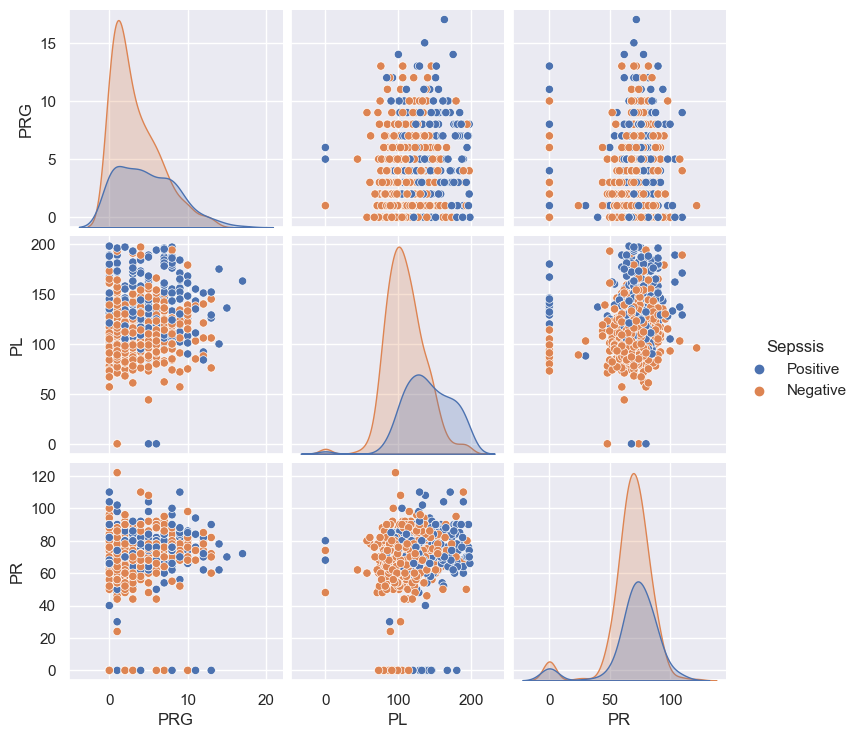

In [31]:
numerical_vars = ['PRG', 'PL', 'PR']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


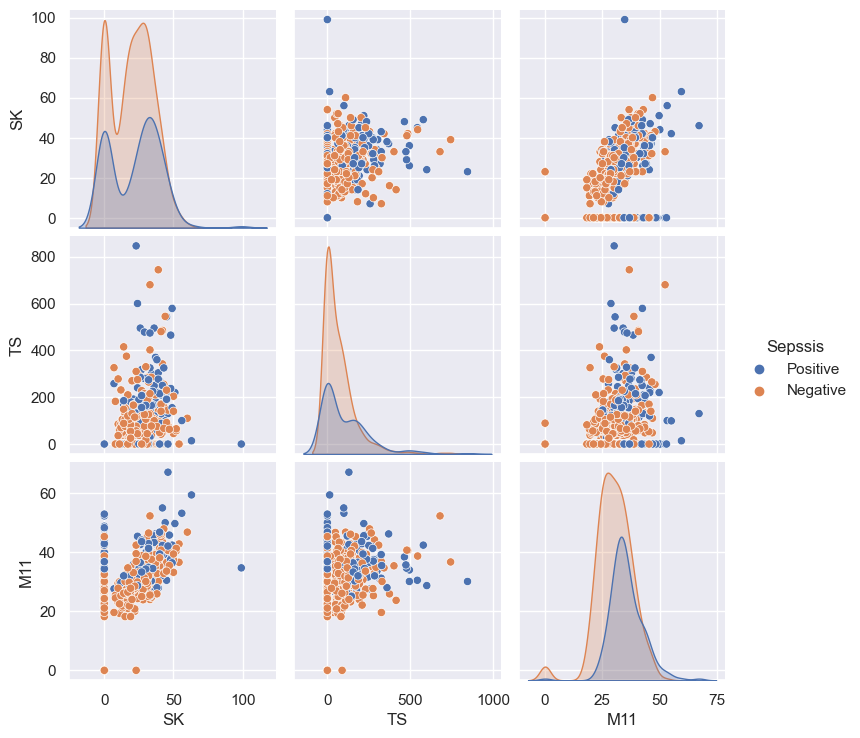

In [32]:
numerical_vars = ['SK', 'TS', 'M11']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


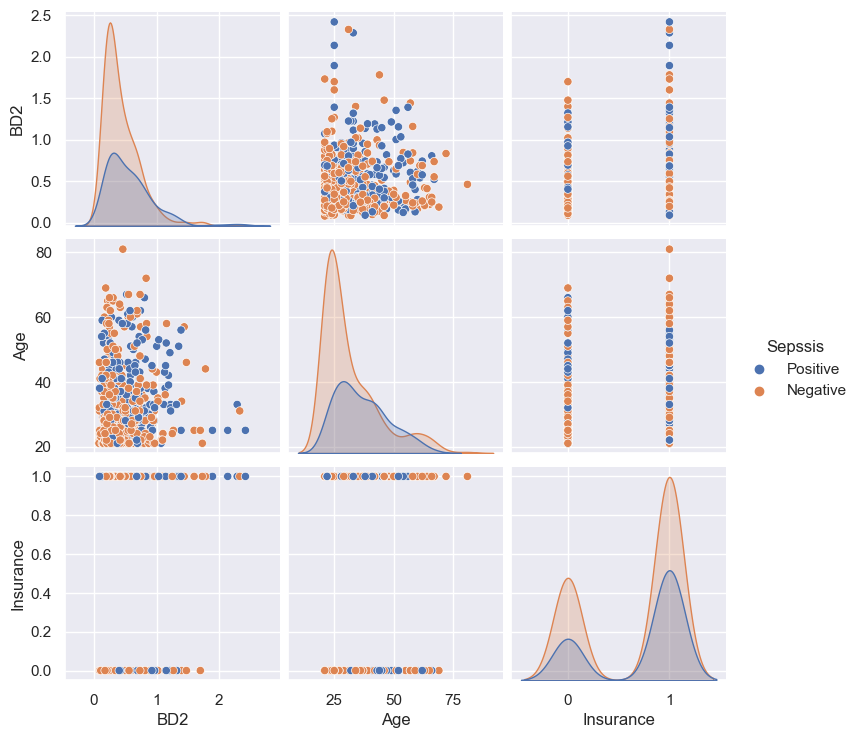

In [33]:
numerical_vars = ['BD2', 'Age', 'Insurance']
sns.pairplot(data=df_tr, vars=numerical_vars, hue='Sepssis')

## Hypothesis Testing

#### Hypothesis 1
- **Null Hypothesis (H0):** There is no significant difference in mean Plasma glucose levels (PRG) between patients with and without sepsis.
- **Alternate Hypothesis (H1):** There is a significant difference in mean Plasma glucose levels (PRG) between patients with and without sepsis.


T-statistic: 5.172721512358376
P-value: 3.154172341568826e-07


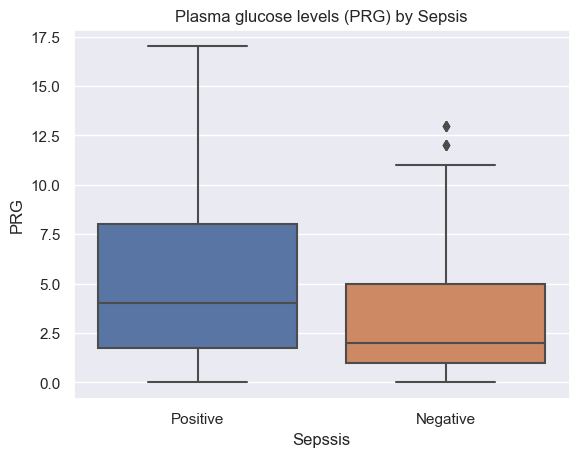

In [34]:
grouped_data = df_tr.groupby('Sepssis')

sepsis_yes = grouped_data.get_group('Positive')
sepsis_no = grouped_data.get_group('Negative')

sepsis_yes_prg = sepsis_yes['PRG']
sepsis_no_prg = sepsis_no['PRG']

t_stat, p_value = stats.ttest_ind(sepsis_yes_prg, sepsis_no_prg)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Sepssis', y='PRG', data=df_tr)
plt.title("Plasma glucose levels (PRG) by Sepsis")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 5.17, and the p-value is significantly smaller than the typical significance level (e.g., 0.05), indicating that the difference in mean Plasma glucose levels (PRG) between patients with and without sepsis is statistically significant.

- Therefore, we reject the null hypothesis (H0) and conclude that there is a significant difference in mean Plasma glucose levels between patients with and without sepsis.

- In conclusion, the results suggest that the mean Plasma glucose levels (PRG) are different between patients with and without sepsis, and this difference is unlikely to have occurred by chance. The boxplot visualization also supports this conclusion, as there seems to be a noticeable difference in the distribution of PRG values between the two groups

#### Hypothesis 2:
- **Null Hypothesis (H0):**
 There is no significant correlation between Blood Pressure (PR) and Body mass index (M11).
- **Alternate Hypothesis (H1):** There is a significant correlation between Blood Pressure (PR) and Body mass index (M11).

Correlation Coefficient: 0.2694817900679736
P-value: 1.9989399562103356e-11


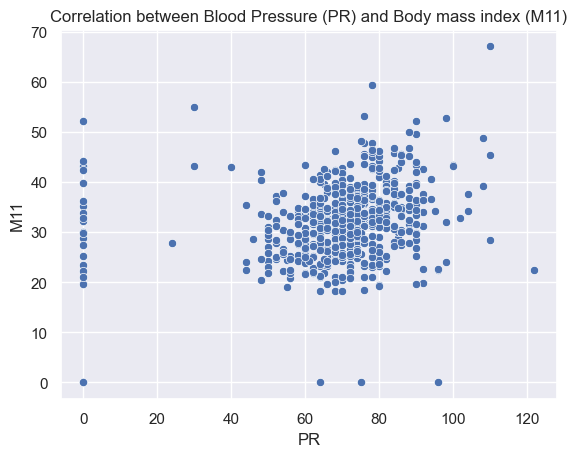

In [35]:
correlation_coefficient, p_value = stats.pearsonr(df_tr['PR'], df_tr['M11'])

print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

sns.scatterplot(x='PR', y='M11', data=df_tr)
plt.title("Correlation between Blood Pressure (PR) and Body mass index (M11)")
plt.show()

##### **Conclusion**
- The correlation coefficient between Blood Pressure (PR) and Body mass index (M11) is approximately 0.27, which indicates a positive correlation between the two variables. A positive correlation means that as one variable increases, the other tends to increase as well.

- The p-value is very small, much smaller than the typical significance level (e.g., 0.05), indicating that the correlation is statistically significant. Therefore, we reject the null hypothesis (H0) and conclude that there is a significant positive correlation between Blood Pressure and Body mass index.

- It can be concluded that, the results suggest that there is a meaningful relationship between Blood Pressure and Body mass index in the dataset, and the strength of this relationship is moderate (correlation coefficient ≈ 0.27)

#### Hypothesis 3:
- **Null Hypothesis (H0):** The distribution of Blood Work Result-1 (PL) is the same for patients with and without valid insurance.
- **Alternate Hypothesis (H1):** The distribution of Blood Work Result-1 (PL) is different for patients with and without valid insurance.

U-statistic: 41481.0
P-value: 0.14753285682539402


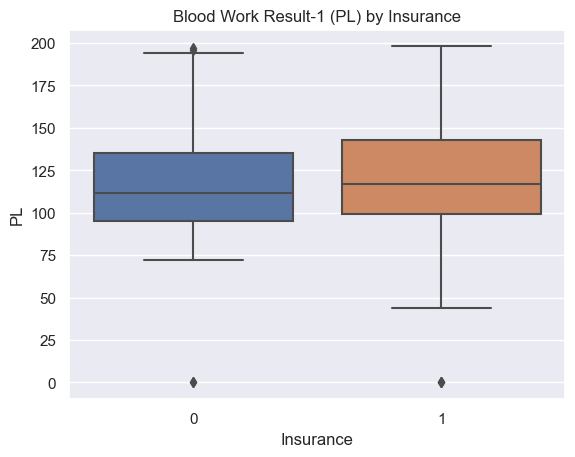

In [37]:
insurance_yes = df_tr[df_tr['Insurance'] == 1]['PL']
insurance_no = df_tr[df_tr['Insurance'] == 0]['PL']

U_stat, p_value = stats.mannwhitneyu(insurance_yes, insurance_no, alternative='two-sided')

print("U-statistic:", U_stat)
print("P-value:", p_value)

sns.boxplot(x='Insurance', y='PL', data=df_tr)
plt.title("Blood Work Result-1 (PL) by Insurance")
plt.show()

##### **Conclusion**
- The Mann-Whitney U test (Wilcoxon rank-sum test) has been used to compare the distribution of Blood Work Result-1 (PL) between patients with and without valid insurance.

- The U-statistic is 41481.0, and the p-value is approximately 0.1475. The p-value is greater than the typical significance level (e.g., 0.05), indicating that we do not have enough evidence to reject the null hypothesis.

- Therefore, we fail to reject the null hypothesis (H0), and we conclude that there is no significant difference in the distribution of Blood Work Result-1 (PL) between patients with and without valid insurance.

- In other words, the results suggest that the distribution of Blood Work Result-1 (PL) does not vary significantly between patients with and without valid insurance. The boxplot visualization also shows that the distributions have a similar shape and overlap considerably, further supporting this conclusion.

#### Hypothesis 4:
- **Null Hypothesis (H0):** The mean age of patients with sepsis is the same as the mean age of patients without sepsis.
- **Alternate Hypothesis (H1):** The mean age of patients with sepsis is different from the mean age of patients without sepsis.

T-statistic: 5.398028835705048
P-value: 1.085959278630566e-07


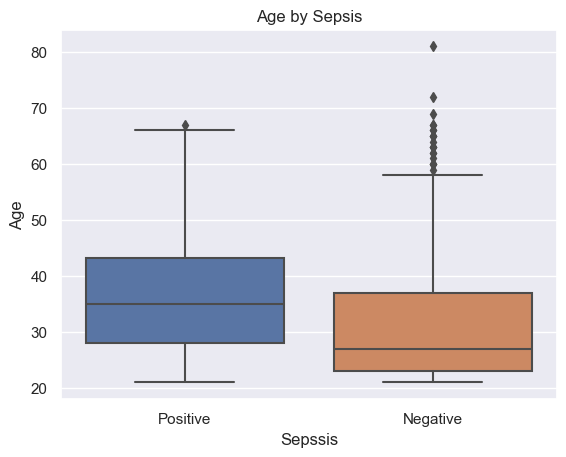

In [39]:
sepsis_yes = df_tr[df_tr['Sepssis'] == 'Positive']['Age']
sepsis_no = df_tr[df_tr['Sepssis'] == 'Negative']['Age']

t_stat, p_value = stats.ttest_ind(sepsis_yes, sepsis_no, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Sepssis', y='Age', data=df_tr)
plt.title("Age by Sepsis")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 5.40, and the p-value is significantly smaller than the typical significance level (e.g., 0.05). This indicates that the difference in mean age between patients with and without sepsis is statistically significant.

- Therefore, we reject the null hypothesis (H0) and conclude that there is a significant difference in mean age between patients with and without sepsis.

- In conclusion, the results suggest that the mean age of patients with sepsis is different from the mean age of patients without sepsis, and this difference is unlikely to have occurred by chance. The boxplot visualization also supports this conclusion, as there seems to be a noticeable difference in the distribution of ages between the two groups.

#### Hypothesis 5:
- **Null Hypothesis (H0):** There is no significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.
- **Alternate Hypothesis (H1):** There is a significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.

T-statistic: 0.15771644627762355
P-value: 0.8747568716697852


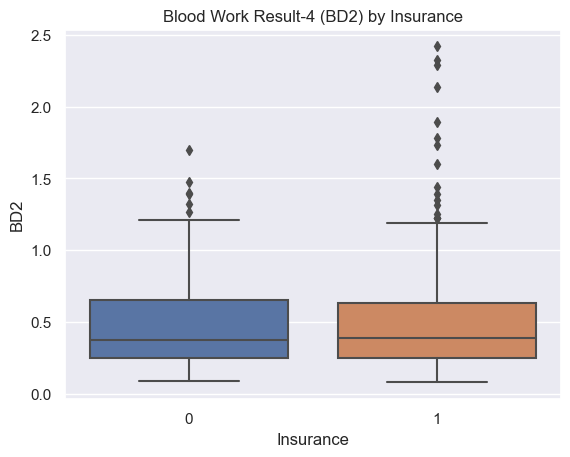

In [41]:
insurance_yes = df_tr[df_tr['Insurance'] == 1]['BD2']
insurance_no = df_tr[df_tr['Insurance'] == 0]['BD2']

t_stat, p_value = stats.ttest_ind(insurance_yes, insurance_no, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

sns.boxplot(x='Insurance', y='BD2', data=df_tr)
plt.title("Blood Work Result-4 (BD2) by Insurance")
plt.show()

##### **Conclusion**
- The t-statistic value is approximately 0.16, and the p-value is greater than the typical significance level (e.g., 0.05). This indicates that we do not have enough evidence to reject the null hypothesis.

- Therefore, we fail to reject the null hypothesis (H0), and we conclude that there is no significant difference in Blood Work Result-4 (BD2) between patients with and without valid insurance.

- In conclusion, the results suggest that the mean Blood Work Result-4 (BD2) is not significantly different between patients with and without valid insurance. The boxplot visualization also shows that the distributions have a similar shape and overlap considerably, further supporting this conclusion.

- It's important to note that the high p-value indicates that the difference between the two groups is likely due to random variation rather than a meaningful difference. This lack of significant difference suggests that Blood Work Result-4 (BD2) may not be associated with insurance status in this dataset. 